# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from alpaca_trade_api.rest import REST, TimeFrame

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
crypto_assets = {
    'BTC':1.2,
    'ETH':5.3
}

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v1/ticker/Ethereum/?convert=CAD" # modified from provided
                                                                       # to show alternative price read below

In [5]:
# Fetch current BTC price using v2 of api.alternative.me URL (URL as provided)
BTC_res = requests.get(btc_url).json()
BTC_ID = list(BTC_res['data'].keys())[0] # dynamically find ID (documented as first key in response dictionary)
                                         # could also just use the ID (1 for BTC, 1027 of ETH), but that could break
                                         # if ID changed for some reason
BTC_price = BTC_res['data'][BTC_ID]['quotes']['USD']['price'] # navigate response to needed value (USD price)

# Fetch current ETH price using v1 of api.alternative.me URL (alternative price read)
ETH_res = requests.get(eth_url).json()
ETH_price = float(ETH_res[0]['price_usd']) # navigate response to needed value (USD price)

# Compute current value of my crpto
my_btc_value = crypto_assets['BTC'] * BTC_price
my_eth_value = crypto_assets['ETH'] * ETH_price

# Print current crypto wallet balance
print(f"The current value of your {crypto_assets['BTC']} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {crypto_assets['ETH']} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $56025.60
The current value of your 5.3 ETH is $17373.88


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
stock_assets = {
    'AGG':200,
    'SPY':50
}

In [7]:
# Set Alpaca API key and secret
alpaca_key = os.getenv("APCA_API_KEY_ID")
secret_key = os.getenv("APCA_API_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_key,
    secret_key
)

### Helper Functions

In [8]:
tradeapi = REST()
#Create Helper functions to pull stock data
def get_company(ticker, start, end, tradeapi, limit=0):
    """
    pulls ticker data using get_bars, adds limit if provided
    """
    if limit != 0:
        return tradeapi.get_bars(
            ticker,
            TimeFrame.Day,
            start,
            end,
            limit=limit
        ).df
    else:
        return tradeapi.get_bars(
            ticker,
            TimeFrame.Day,
            start,
            end
        ).df
def get_companies(tickers, start, end, tradeapi,limit=0):
    """
    pulls multiple tickers data using get_company, appends all listed stocks to a single database
    """
    df_base = {}
    for ticker in tickers:
        df_base[ticker]=get_company(ticker=ticker,
                                    start=start,
                                    end=end,
                                    tradeapi=tradeapi,
                                    limit=limit)
    return pd.concat(df_base.values(), keys=df_base.keys(), axis="columns")

In [9]:
# Format current date as ISO format
# Not needed with since .get_barset() has been deprecated

# Set the tickers
tickers = ["AGG","SPY"]

# Get current closing prices for SPY and AGG
data = get_companies(
    tickers,
    end=(pd.Timestamp.today()-pd.Timedelta('1d')).date(), # Cannot Run on today's values
    start=(pd.Timestamp.today()-pd.Timedelta('5d')).date(),
    tradeapi=tradeapi,
    limit=1
).reset_index()
data['AGG']['close']

0    106.75
Name: close, dtype: float64

In [10]:
# Pick AGG and SPY close prices
agg_close_price=data['AGG']['close'][0]
spy_close_price=data["SPY"]['close'][0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price:.2f}")
print(f"Current SPY closing price: ${spy_close_price:.2f}")

Current AGG closing price: $106.75
Current SPY closing price: $449.59


In [11]:
# Compute the current value of shares
my_agg_value=stock_assets['AGG']*agg_close_price
my_spy_value=stock_assets['SPY']*spy_close_price

# Print current value of shares
print(f"The current value of your {stock_assets['AGG']} AGG shares is ${my_agg_value:.2f}")
print(f"The current value of your {stock_assets['SPY']} SPY shares is ${my_spy_value:.2f}")

The current value of your 200 AGG shares is $21350.00
The current value of your 50 SPY shares is $22479.50


### Savings Health Analysis

In [12]:
# Set monthly household income
monthly_income=12000

# Consolidate financial assets data
total_crypto = my_btc_value+my_eth_value
total_shares = my_agg_value+my_spy_value

# Create savings DataFrame
df_savings=pd.DataFrame({
    'amount':[total_crypto,total_shares]
},index=['crypto','shares'])

# Display savings DataFrame
df_savings

,amount
crypto,73399.477
shares,43829.500


<AxesSubplot:ylabel='amount'>

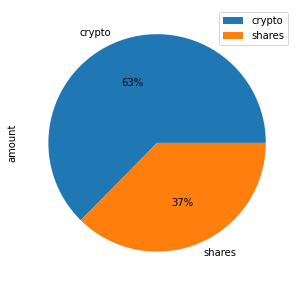

In [13]:
# Plot savings pie chart
df_savings.plot.pie(y='amount',figsize=(5, 5), autopct='%1.f%%')

In [14]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.sum()[0]

# Validate saving health
if total_savings>emergency_fund:
    print("Congratulations! You have enough money in your emergency fund.")
elif total_savings==emergency_fund:
    print("Congratulations! You have just enough for your emergency fund.")
else:
    print("Congratulations! You have a reason to add to your emergency fund.")


Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [15]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [16]:
# Get 5 years' worth of historical data for SPY and AGG
    # (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stocks = get_companies(
    tickers,
    start=start_date,
    end=end_date,
    tradeapi = tradeapi,
    limit=1000
)

# Display sample data
df_stocks.head()

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.61  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.81  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.86  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.14  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.97  2718710   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2016-05-02 04:00:00+00:00       15119  110.627199  206.90  208.18  206.41   
2016-05-03 04:00:00+00:00       15662  110.865995  206.50  206.80  205.28   
2016-05-04 04:00:00+00:00       13982  110.879063  205.00  205.85  204.42   
2016-05-05 04:00:00+00:00       15707  111.028363  205.57  205.98  204.47   
2016-05-06 04:00:00+00:00       12697  111.031967  204.04  205.77  203.88   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2016-05-02 04:00:00+00:00  208.03   61908515      263580  207.294812  
2016-05-03 04:00:00+00:00  206.13  106422142      377518  206.312060  
2016-05-04 04:00:00+00:00  204.96   92199810      345261  205.090172  
2016-05-05 04:00:00+00:00  204.95   67597222      280622  205.141555  
2016-05-06 04:00:00+00:00  205.70   89131004      340335  204.937074

In [17]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns (500 runs)
MCSim_30yr_500 = MCSimulation(
    df_stocks,
    weights = [.4, .6],
    num_simulation=500,
    num_trading_days=(252*30)
    )

In [18]:
# Printing the simulation input data
def Simulation_Summary(simulation,tickers):
    return f"Running a simulation on {tickers} with Weight of {simulation.weights}. Will Run {simulation.nSim} simulations each spanning {simulation.nTrading} trading days."
Simulation_Summary(MCSim_30yr_500,tickers)

"Running a simulation on ['AGG', 'SPY'] with Weight of [0.4, 0.6]. Will Run 500 simulations each spanning 7560 trading days."

In [ ]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MCSim_30yr_500.calc_cumulative_return()

### Retirement Analysis

In [20]:
# Monte Carlo Helper Functions
def display_monte_carlo(simulation):
    #plot simulation runs
    simulation.plot_simulation()
    #need to clear a plot so the distribution is not overlayed in line
    simulation.plot_simulation().clear()
    #plot distribution
    simulation.plot_distribution()
    #return the statistics to lead the graphs so data has context
    print(simulation.summarize_cumulative_return())

count           500.000000
mean              5.972400
std               4.457722
min               0.680792
25%               3.105153
50%               4.834530
75%               7.247696
max              31.145008
95% CI Lower      1.308580
95% CI Upper     19.787924
Name: 7560, dtype: float64


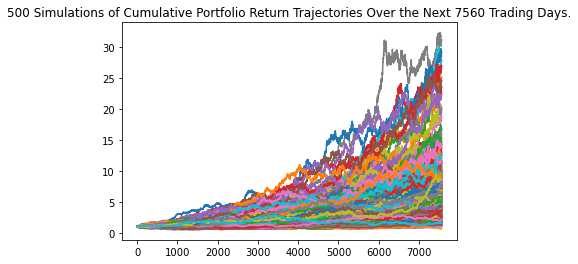

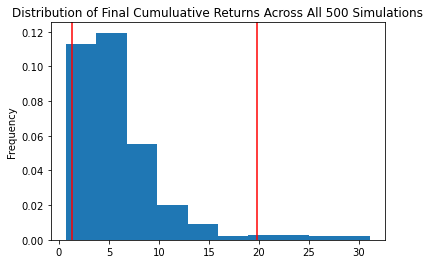

In [21]:
# Plot simulation outcomes
# Plot probability distribution and confidence intervals
# Fetch summary statistics from the Monte Carlo simulation results
# Print summary statistics
display_monte_carlo(MCSim_30yr_500)

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
# Use Helper function to reduce repetition
def confidence_interval(initial_investment,simulation):
    results = simulation.summarize_cumulative_return()
    ci_lower = round(results[8]*initial_investment,2)
    ci_upper = round(results[9]*initial_investment,2)
    num_years = int(round(simulation.nTrading/252,0))
    return (f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
            f" over the next {num_years} years will end within in the range of"
            f" ${ci_lower} and ${ci_upper}")

# Print results
confidence_interval(initial_investment,MCSim_30yr_500)

'There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $26171.6 and $395758.49'

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
confidence_interval(initial_investment,MCSim_30yr_500)

'There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $39257.4 and $593637.73'

## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MCSim_5yr_500 = MCSimulation(
    df_stocks,
    weights = [.4, .6],
    num_simulation=500,
    num_trading_days=(252*5)
    )

In [ ]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
print(Simulation_Summary(MCSim_5yr_500,tickers))
MCSim_5yr_500.calc_cumulative_return()

count           500.000000
mean              1.341236
std               0.350396
min               0.648293
25%               1.088654
50%               1.302104
75%               1.552208
max               2.607116
95% CI Lower      0.776082
95% CI Upper      2.166224
Name: 1260, dtype: float64


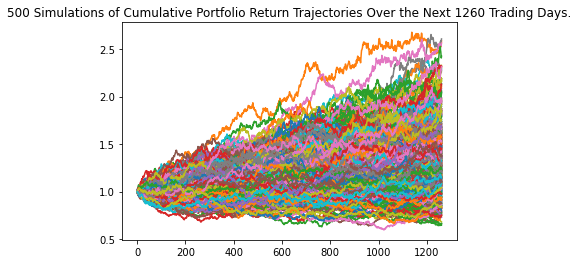

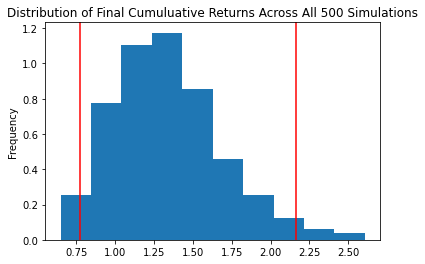

In [26]:
# Plot simulation outcomes
# Plot probability distribution and confidence intervals
# Fetch summary statistics from the Monte Carlo simulation results
# Print summary statistics
display_monte_carlo(MCSim_5yr_500)

In [27]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
confidence_interval(initial_investment,MCSim_5yr_500)

'There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $46564.91 and $129973.45'

### Ten Years Retirement Option

In [28]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MCSim_10yr_500 = MCSimulation(
    df_stocks,
    weights = [.4, .6],
    num_simulation=500,
    num_trading_days=(252*10)
    )

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
print(Simulation_Summary(MCSim_10yr_500,tickers))
MCSim_10yr_500.calc_cumulative_return()

count           500.000000
mean              1.761622
std               0.656802
min               0.640751
25%               1.278304
50%               1.627363
75%               2.064856
max               5.053397
95% CI Lower      0.860659
95% CI Upper      3.339964
Name: 2520, dtype: float64


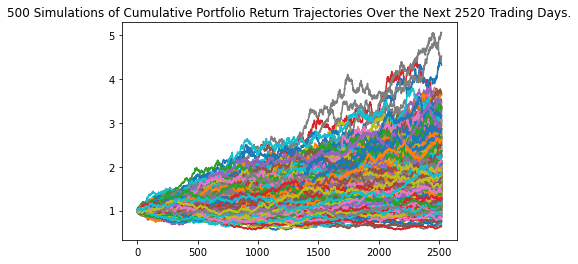

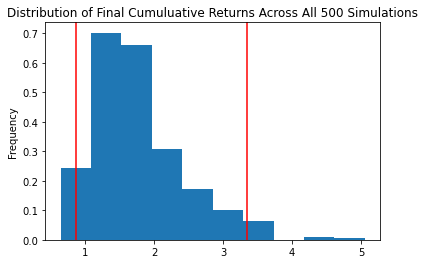

In [30]:
# Plot simulation outcomes
# Plot probability distribution and confidence intervals
# Fetch summary statistics from the Monte Carlo simulation results
# Print summary statistics
display_monte_carlo(MCSim_10yr_500)

In [31]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
confidence_interval(initial_investment,MCSim_10yr_500)

'There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $51639.57 and $200397.87'